In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from operator import attrgetter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve

path = Path("../data")

TAKEAWAYS
- Sparse target class (7.7% positives)
- ROC AUC and PRCURVE AUC used as metrics
- Since it is a simple model in relation to data, regularization does not have much effect

In [9]:
df = pd.read_parquet(path / "full_data.parquet")

In [10]:
df.churn.value_counts()[1]/(len(df))*100

7.707464276204846

Target is quite unbalanced 

In [19]:
def get_cols_to_drop():

    drop_cols = [
                'churn',
                'advertiser_zrive_id',
                'period_int',
                'month_period',
                'monthly_avg_ad_price', #has nans
                'monthly_distinct_ads', #has nans
                ]

    return drop_cols


In [12]:
def split_by_date(data, execution_month, train_months = 6):
    """
    Splits data into train and test sets based on a date
    """
    df = data.sort_values('month_period')
    train_start = execution_month.to_timestamp() - pd.DateOffset(months=train_months)

    train = df[(df['month_period'] >= train_start.to_period('M')) & (df['month_period'] < execution_month)]
    test = df[df['month_period'] == execution_month]

    drop_cols = get_cols_to_drop()
    X_train = train.drop(columns=drop_cols)
    y_train = train['churn']
    X_test = test.drop(columns=drop_cols)
    y_test = test['churn']
    
    return X_train, X_test, y_train, y_test

In [13]:
def scale(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train) 
    X_test = scaler.transform(X_test) 

    return X_train, X_test

In [14]:
def train_model(model, X_train, y_train):
    """
    Trains model and evaluates using ROC AUC and PR AUC
    """

    model.fit(X_train, y_train)

    return model


In [15]:
def evaluate_model(y_test, y_scores):
 
    roc = roc_auc_score(y_test, y_scores)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    prc = auc(recall, precision)

    return {
        'roc_auc': roc,
        'pr_auc': prc,
    }


In [43]:
def plot_curves(y, y_scores):

    fpr, tpr, thresholds = roc_curve(y, y_scores)
    roc_auc = auc(fpr, tpr)
    prec, rec, thresholds = precision_recall_curve(y, y_scores)
    pr_auc = auc(rec, prec)

    fig, axs  = plt.subplots(1,2, figsize=(12, 5))
    
    axs[0].plot(fpr, tpr, label= f'{model}, AUC = %.2f' % roc_auc)
    axs[1].plot(rec, prec, label= f'{model}, AUC = %.2f' % pr_auc)

    axs[0].set_title('ROC curve')
    axs[0].set_xlabel('False positive rate')
    axs[0].set_ylabel('True positive rate')
    axs[0].legend(loc="lower right")

    axs[1].set_title('Precision-recall curve')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].legend(loc="upper right")

In [64]:
def run_for_all_dates(data, model, execution_months, train_months = 6):
    """
    Rolls over execution_months, applies split, train and eval, returns results
    """
    train_results = []
    test_results = []

    for execution_month in execution_months:
        X_train, X_test, y_train, y_test = split_by_date(data, execution_month, train_months)
        X_train, X_test = scale(X_train, X_test)
        model = train_model(model,X_train, y_train)

        y_scores_train = model.predict_proba(X_train)[:, 1]
        y_scores_test = model.predict_proba(X_test)[:, 1]

        train_metrics = evaluate_model(y_train, y_scores_train)
        train_metrics['execution_month'] = execution_month.to_timestamp()
        test_metrics = evaluate_model(y_test, y_scores_test)
        test_metrics['execution_month'] = execution_month.to_timestamp()

        train_results.append(train_metrics)
        test_results.append(test_metrics)

    return pd.DataFrame(train_results), pd.DataFrame(test_results)


In [80]:
execution_months = np.sort(df['month_period'].unique())[1:]
train_months = 6
model = LogisticRegression(max_iter=300)

train_results,test_results = run_for_all_dates(data=df,model=model,execution_months=execution_months,train_months = 6)

In [70]:
def auc_boxplot(results):
    fig, ax = plt.subplots(1,2)

    ax[0].boxplot(results.roc_auc)
    ax[1].boxplot(results.pr_auc)


    ax[0].set_title('roc_auc')
    ax[1].set_title('pr_auc')

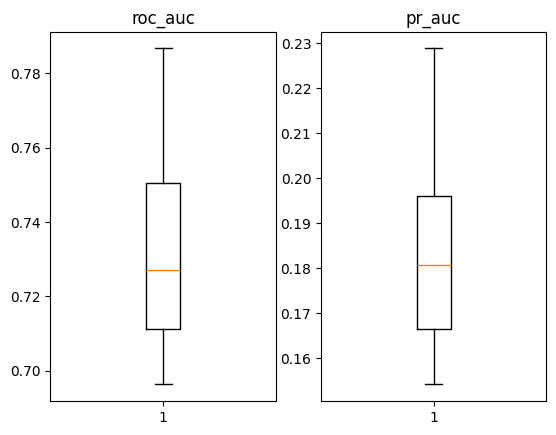

In [81]:
auc_boxplot(train_results)

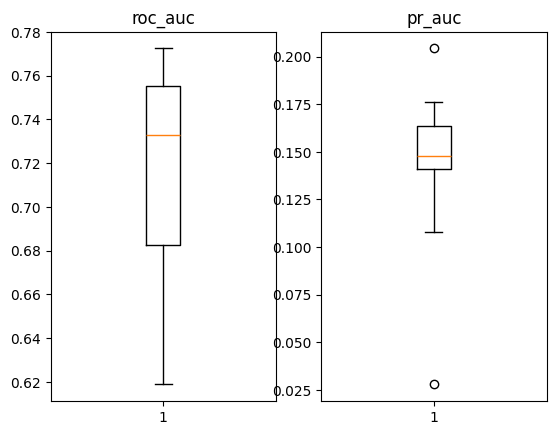

In [82]:
auc_boxplot(test_results)

There is some overfitting

In [89]:
execution_month = pd.to_datetime('2023-11-01').to_period('M')

X_train, X_test, y_train, y_test = split_by_date(df, execution_month, train_months)
X_train, X_test = scale(X_train, X_test)
model = train_model(model,X_train, y_train)

y_scores_train = model.predict_proba(X_train)[:, 1]
y_scores = model.predict_proba(X_test)[:, 1]



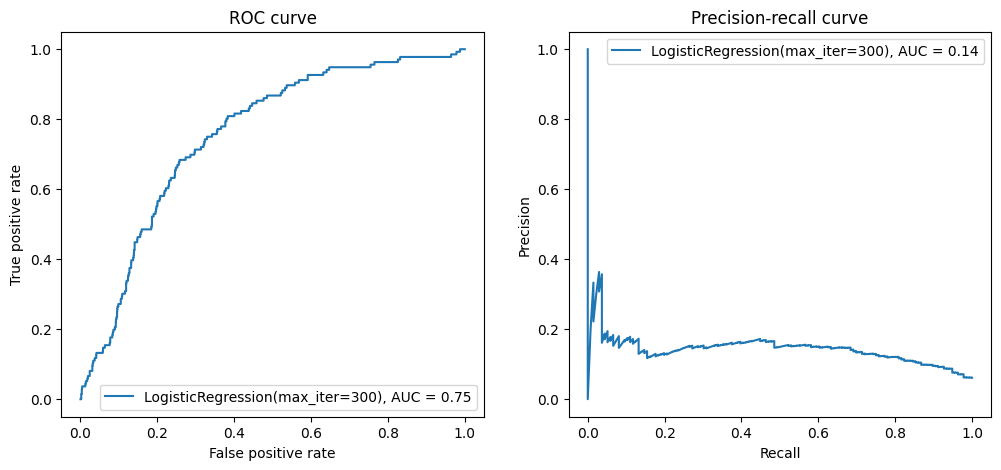

In [85]:
plot_curves(y_test, y_scores)


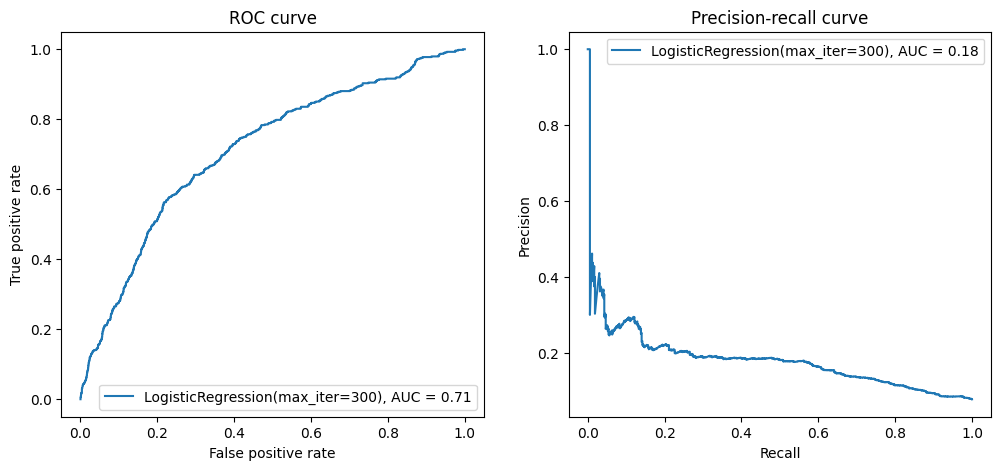

In [ ]:
plot_curves(y_train, y_scores_train)


In [109]:
execution_months = np.sort(df['month_period'].unique())[1:]
train_months = 6
model = LogisticRegression(C=1e-5,max_iter=300)

train_results,test_results = run_for_all_dates(data=df,model=model,execution_months=execution_months,train_months = 6)

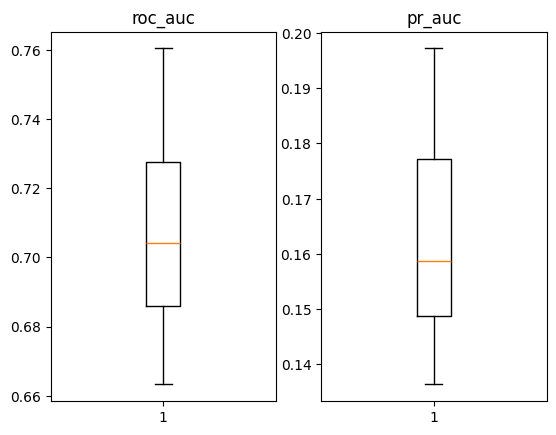

In [110]:
auc_boxplot(train_results)

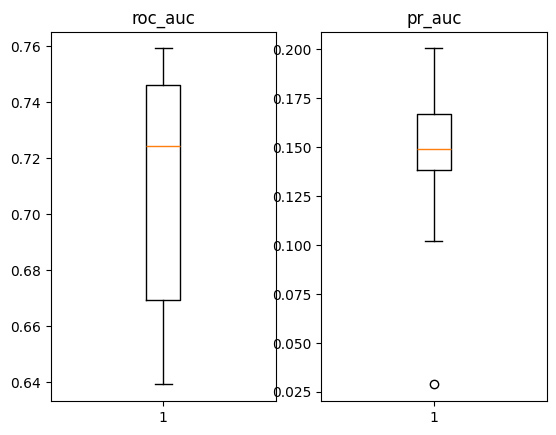

In [111]:
auc_boxplot(test_results)

In [112]:
X_train, X_test, y_train, y_test = split_by_date(df, execution_month, train_months)
X_train, X_test = scale(X_train, X_test)
model = train_model(model,X_train, y_train)

y_scores_train = model.predict_proba(X_train)[:, 1]
y_scores = model.predict_proba(X_test)[:, 1]


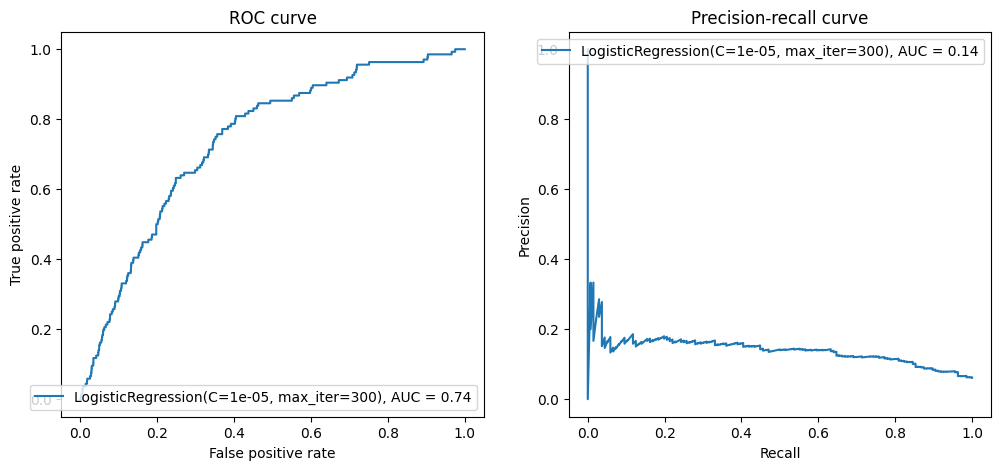

In [91]:
plot_curves(y_test, y_scores)


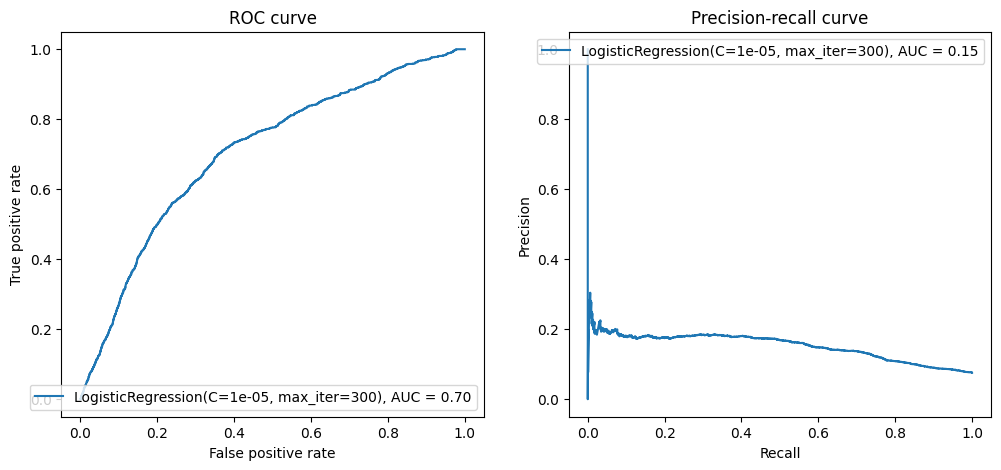

In [113]:
plot_curves(y_train, y_scores_train)
